In [1]:
import numpy as np
import seaborn as sns;
import pandas as pd
import itertools
import keras
import numba

from matplotlib import pyplot as plt
from sklearn.datasets import make_blobs

from pycpd import RigidRegistration
from pycpd import AffineRegistration
from pycpd import DeformableRegistration

In [2]:
from proglearn.sims import generate_gaussian_parity
from proglearn.progressive_learner import ProgressiveLearner
from proglearn.deciders import SimpleArgmaxAverage
from proglearn.transformers import (
    TreeClassificationTransformer,
    NeuralClassificationTransformer)
from proglearn.voters import TreeClassificationVoter, KNNClassificationVoter
from proglearn.sims import generate_gaussian_parity

# Functions

In [3]:
#Function to rotate distribution
def rotate(X, theta=0, dim=[0,1]):
    #dimensions to rotate
    Z = X[:, dim]
    
    #rotation
    c, s = np.cos(theta), np.sin(theta)
    R = np.array([[c, -s], [s, c]])
    Z = Z @ R
    
    #recombine
    X[:, dim] = Z
    
    return X

#Function to shear in the X direction
def shearX(X, s=0, dim=[0,1]):
    #dimensions to shear
    Z = X[:, dim]
    
    #shear
    R = np.array([[1, 0], [s, 1]])
    Z = Z @ R
    
    #recombine
    X[:, dim] = Z
    
    return X

#Function to shear in the Y direction
def shearY(X, s=0, dim=[0,1]):
    #dimensions to shear
    Z = X[:, dim]
    
    #shear
    R = np.array([[1, s], [0, 1]])
    Z = Z @ R
    
    #recombine
    X[:, dim] = Z
    
    return X

#Function to double shear in the X direction
def double_shearX(X, y, ss=(0,0) , dim=[0,1]):
    #dimensions to shear
    Z = X[:, dim]
    i,j = dim
    t,b = ss
    
    Z_top = Z[Z[:,j] >= 0]
    Z_bot = Z[Z[:,j] < 0]
    c_top = y[Z[:,j] >= 0]
    c_bot = y[Z[:,j] < 0]
    
    #shear
    R_top = np.array([[1, 0], [t, 1]])
    R_bot = np.array([[1, 0], [b, 1]])
    Z_top = Z_top @ R_top
    Z_bot = Z_bot @ R_bot
    
    #recombine
    Z = np.concatenate((Z_top, Z_bot))
    y = np.concatenate((c_top, c_bot))
    X[:, dim] = Z
    
    return X, y

In [4]:
def generate_gaussian_parity(n_samples, centers=None, class_label=None,
    cluster_std=0.25, random_state=None):

    if random_state != None:
        np.random.seed(random_state)

    if centers == None:
        centers = np.array([(-0.5, 0.5), (0.5, 0.5), (-0.5, -0.5), (0.5, -0.5)])

    if class_label == None:
        class_label = [0, 1, 1, 0]

    blob_num = len(class_label)

    # get the number of samples in each blob with equal probability
    samples_per_blob = np.random.multinomial(
        n_samples, 1 / blob_num * np.ones(blob_num)
    )

    X, y = make_blobs(
        n_samples=samples_per_blob,
        n_features=2,
        centers=centers,
        cluster_std=cluster_std,
    )

    for blob in range(blob_num):
        y[np.where(y == blob)] = class_label[blob]

    return X, y

# Visualizing Transformation

In [5]:
X1, y1 = generate_gaussian_parity(1000);
X2, y2 = generate_gaussian_parity(1000);
X3, y3 = generate_gaussian_parity(1000);
X4, y4 = generate_gaussian_parity(1000);

X2 = rotate(X2, theta=np.pi/6);
X3 = shearX(X3, s=1);
X4, y4 = double_shearX(X4, y4, ss=(1,0));

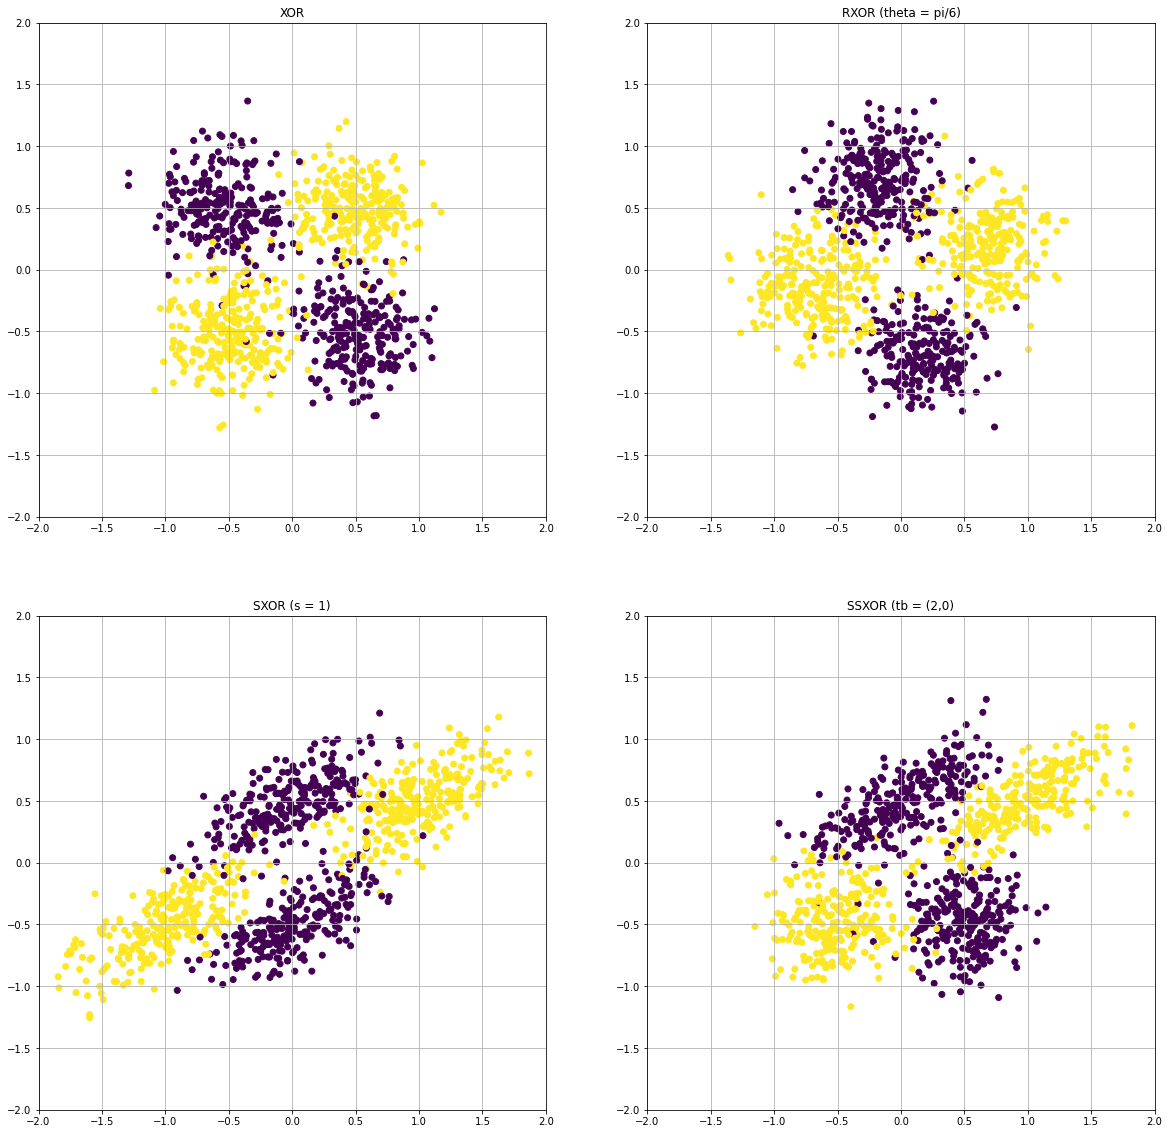

In [6]:
plt.figure(figsize=(20,20));

plt.subplot(221);
plt.scatter(X1[:,0], X1[:,1], c=y1);
plt.title("XOR");
plt.xlim([-2,2]); plt.ylim([-2,2]);
plt.grid();

plt.subplot(222);
plt.scatter(X2[:,0], X2[:,1], c=y2);
plt.title("RXOR (theta = pi/6)");
plt.xlim([-2,2]); plt.ylim([-2,2]);
plt.grid();

plt.subplot(223);
plt.scatter(X3[:,0], X3[:,1], c=y3);
plt.title("SXOR (s = 1)");
plt.xlim([-2,2]); plt.ylim([-2,2]);
plt.grid();

plt.subplot(224);
plt.scatter(X4[:,0], X4[:,1], c=y4);
plt.title("SSXOR (tb = (2,0)");
plt.xlim([-2,2]); plt.ylim([-2,2]);
plt.grid();

# Visualizing Decision Boundaries for Shear

In [7]:
from matplotlib.colors import ListedColormap
cmap_light = ListedColormap(['#FFBBBB', '#BBFFBB', '#BBBBFF'])
cmap_bold = ListedColormap(['#CC0000', '#00AA00', '#0000CC'])

#Grid Setup
l = 3
h = 0.05 
xx, yy = np.meshgrid(np.arange(-l, l, h), np.arange(-l, l, h))
grid = np.c_[xx.ravel(), yy.ravel()]

In [8]:
#distribution generation
X = [];
y = [];

S = [-100, -10, -5, -2, -1, -0.5, 0, 0.5, 1, 2, 5, 10, 100];

for i in S:
    D,c = generate_gaussian_parity(1000);
    D = shearX(D, s=i);
    
    X.append(D);
    y.append(c);

#Original XOR
U,v = generate_gaussian_parity(1000);

In [9]:
#Prarameters
n_trees=10
max_depth=None

c = [];
p = [];

for i in range(len(S)):
    #Model
    default_transformer_class = TreeClassificationTransformer
    default_transformer_kwargs = {"kwargs" : {"max_depth" : max_depth}}

    default_voter_class = TreeClassificationVoter
    default_voter_kwargs = {}

    default_decider_class = SimpleArgmaxAverage
    default_decider_kwargs = {"classes" : np.arange(2)}
    progressive_learner = ProgressiveLearner(
        default_transformer_class = default_transformer_class,
        default_transformer_kwargs = default_transformer_kwargs,
        default_voter_class = default_voter_class,
        default_voter_kwargs = default_voter_kwargs,
        default_decider_class = default_decider_class,
        default_decider_kwargs = default_decider_kwargs)

    #Training and Prediction
    progressive_learner.add_task(U, v, num_transformers=n_trees)
    progressive_learner.add_task(X[i], y[i], num_transformers=n_trees)
    
    z = progressive_learner.predict(grid, task_id=0)
    q = progressive_learner.task_id_to_decider[0].predict_proba(grid)[:,0]
    
    #Store values
    c.append(z)
    p.append(q)

In [10]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

C:\Users\William\anaconda3\envs\NDD\lib\site-packages\ipykernel_launcher.py:25: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
C:\Users\William\anaconda3\envs\NDD\lib\site-packages\ipykernel_launcher.py:31: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


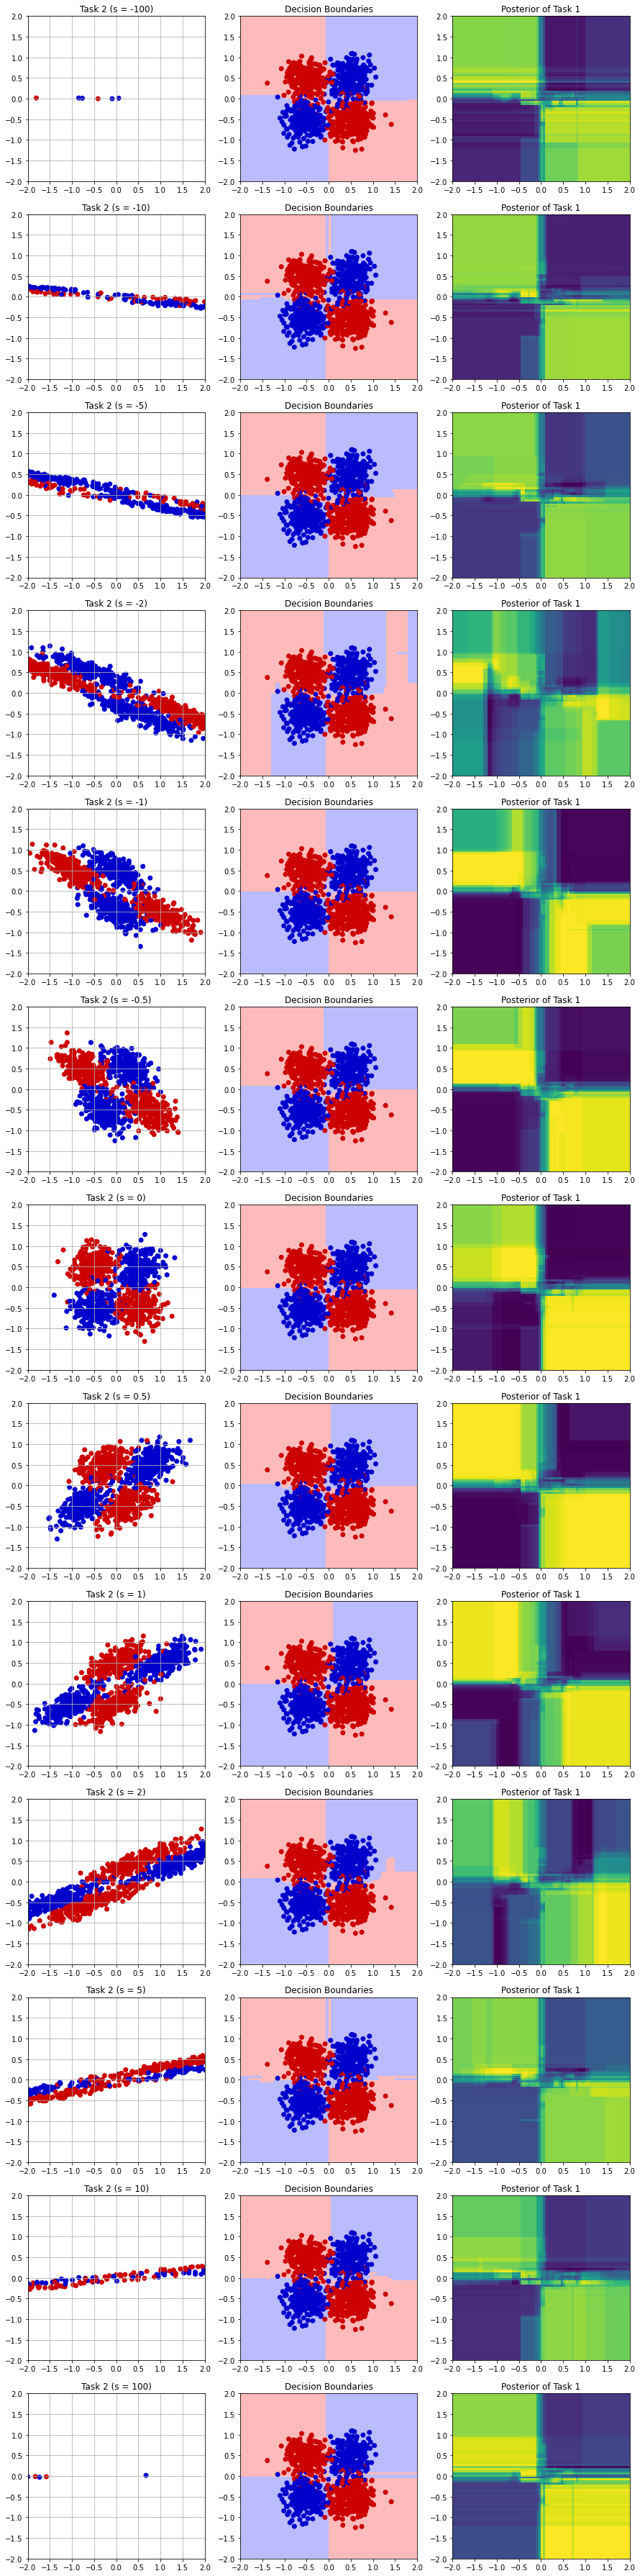

In [11]:
#Plot Decisions
l = 2;
w = 3;
n = len(S)
plt.figure(figsize=(w*5, n*5))

for i in range(n):
    #Decision Boundary
    zz = c[i];
    zz = zz.reshape(xx.shape);
    
    #Posteriors
    pp = p[i];
    pp = pp.reshape(xx.shape);
    
    #Task 2 Distribution
    x = X[i];
    
    plt.subplot(n,w, w*i+1);
    plt.scatter(x[:,0], x[:,1], c=y[i], cmap=cmap_bold);
    plt.xlim([-l,l]); plt.ylim([-l,l]);
    plt.grid(); plt.title('Task 2 (s = {})'.format(S[i]));
    
    plt.subplot(n,w, w*i+2);
    plt.pcolormesh(xx, yy, zz, cmap=cmap_light);
    plt.scatter(U[:,0], U[:,1], c=v, cmap=cmap_bold);
    plt.xlim([-l,l]); plt.ylim([-l,l]);
    plt.title('Decision Boundaries');
    
    plt.subplot(n,w, w*i+3);
    plt.pcolormesh(xx, yy, pp);
    plt.xlim([-l,l]); plt.ylim([-l,l]);
    plt.title('Posterior of Task 1');